In [2]:
"""Backend supported: tensorflow.compat.v1, tensorflow, pytorch, paddle"""
import deepxde as dde
import numpy as np

Primero se da valores a los parámetros del problema y se definen el residuo (pde) y el dominio espacial (geom) y temporal (timedomain). Después se define el dominio espacio-temporal (geomtime).

In [3]:
# Problem parameters:
a = 0.4  # Thermal diffusivity
L = 1  # Length of the bar
n = 1  # Frequency of the sinusoidal initial conditions

def pde(x, y):
    """Expresses the PDE residual of the heat equation."""
    dy_t = dde.grad.jacobian(y, x, i=0, j=1)
    dy_xx = dde.grad.hessian(y, x, i=0, j=0)
    return dy_t - a * dy_xx


# Computational geometry:
geom = dde.geometry.Interval(0, L)
timedomain = dde.geometry.TimeDomain(0, 1)
geomtime = dde.geometry.GeometryXTime(geom, timedomain)

A continuación, se definen las condiciones de contorno (Neumann) y las iniciales (en este caso un coseno).

In [4]:
# Initial and boundary conditions:
bc = dde.icbc.NeumannBC(geomtime, lambda x: 0, lambda _, on_boundary: on_boundary)
ic = dde.icbc.IC(
    geomtime,
    lambda x: np.cos(np.pi * x[:, 0:1] / L),
    lambda _, on_initial: on_initial,
)

Ahora se pueden definir el problema y la red.

Por defecto, la distribución de puntos de entrenamiento es aleatoria (distribución Hammersley) y los puntos de entrenamiento se distribuyen uniformemente. Los puntos de contorno e iniciales son los mismos para training y testing.

En primer lugar, se usará la red y el número de puntos del ejemplo de la página de DeepXDE.

In [6]:
# Define the PDE problem and configurations of the network:
data = dde.data.TimePDE(
    geomtime, # dominio
    pde, # residuo a minimizar
    [bc, ic], # condiciones
    num_domain=2540, # training points dentro del dominio
    num_boundary=80, # training/test points en el contorno
    num_initial=160, # training/test points en t=0
    num_test=2540, # test points dentro del dominio
)
net = dde.nn.FNN([2] + [20] * 3 + [1], "tanh", "Glorot normal")
base_model = dde.Model(data, net)

Se compila y se entrena dos veces. Según el ejemplo de la página, L-BFGS se usa para reducir el error lo máximo posible.

In [7]:
# Build and train the model:
base_model.compile("adam", lr=1e-3)
base_model.train(iterations=20000)
base_model.compile("L-BFGS")
base_losshistory, base_train_state = base_model.train()

Compiling model...
'compile' took 0.016729 s

Training model...



C:\Users\reloj\anaconda3\lib\site-packages\keras\initializers\initializers_v2.py:120: UserWarning: The initializer GlorotNormal is unseeded and being called multiple times, which will return identical values  each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initalizer instance more than once.
  warnings.warn(


Instructions for updating:
Lambda fuctions will be no more assumed to be used in the statement where they are used, or at least in the same block. https://github.com/tensorflow/tensorflow/issues/56089
Cause: could not parse the source code of <function <lambda> at 0x000001E454344B80>: no matching AST found among candidates:
# coding=utf-8
lambda x, on: np.array([on_boundary(x[i], on[i]) for i in range(len(x))])
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Cause: could not parse the source code of <function <lambda> at 0x000001E454344B80>: no matching AST found among candidates:
# coding=utf-8
lambda x, on: np.array([on_boundary(x[i], on[i]) for i in range(len(x))])
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Step      Train loss                        Test loss                         Test metric
0         [2.59e-01, 1.25e-03, 5.24e-01]    [2.47e-01, 1.25e-03, 5.24e-01]    []  
1000      

La red se ha entrenado durante 20008 etapas y ahora se pinta la evolución del residuo para training y testing. Como los puntos de contorno son iguales para ambos, el error también es igual.

Nótese que el error de training es mayor que el de testing.

Saving loss history to C:\Users\reloj\Documents\loss.dat ...
Saving training data to C:\Users\reloj\Documents\train.dat ...
Saving test data to C:\Users\reloj\Documents\test.dat ...


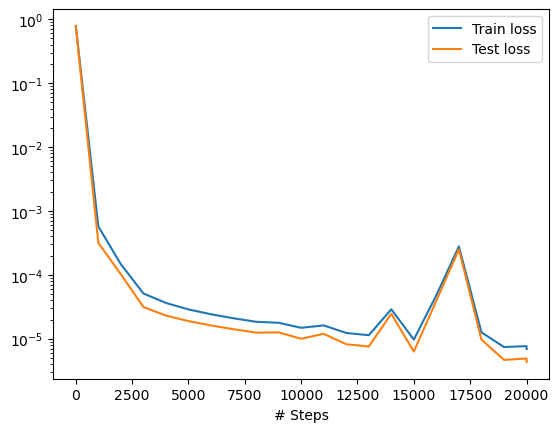

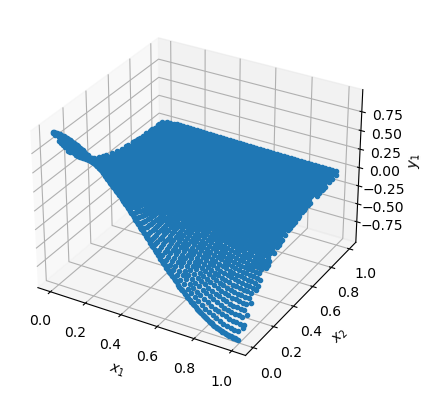

In [8]:
# Plot/print the results
dde.saveplot(base_losshistory, base_train_state, issave=True, isplot=True)

La siguiente red usa la función de activación ReLU y la misma cantidad de puntos.

In [9]:
# Define the PDE problem and configurations of the network:
data = dde.data.TimePDE(
    geomtime,
    pde, # minimize residual
    [bc, ic],
    num_domain=2540,
    num_boundary=80,
    num_initial=160,
    num_test=2540,
)
net = dde.nn.FNN([2] + [20] * 3 + [1], "relu", "Glorot normal")
relu_model = dde.Model(data, net)

In [11]:
# Build and train the model:
relu_model.compile("adam", lr=1e-3)
relu_model.train(iterations=20000)
relu_model.compile("L-BFGS")
relu_losshistory, relu_train_state = relu_model.train()

Compiling model...
'compile' took 0.007169 s

Training model...

Step      Train loss                        Test loss                         Test metric
0         [4.47e-03, 3.76e-04, 5.00e-01]    [4.86e-03, 3.76e-04, 5.00e-01]    []  
1000      [1.89e-04, 2.10e-04, 6.44e-05]    [1.74e-04, 2.10e-04, 6.44e-05]    []  
2000      [9.46e-06, 3.66e-07, 1.08e-05]    [9.19e-06, 3.66e-07, 1.08e-05]    []  
3000      [3.97e-06, 1.18e-09, 1.04e-05]    [3.87e-06, 1.18e-09, 1.04e-05]    []  
4000      [2.58e-06, 1.67e-09, 9.61e-06]    [2.42e-06, 1.67e-09, 9.61e-06]    []  
5000      [2.07e-06, 1.82e-09, 8.44e-06]    [1.71e-06, 1.82e-09, 8.44e-06]    []  
6000      [1.44e-06, 7.52e-10, 7.47e-06]    [1.42e-06, 7.52e-10, 7.47e-06]    []  
7000      [9.39e-07, 6.48e-08, 6.70e-06]    [6.59e-07, 6.48e-08, 6.70e-06]    []  
8000      [4.02e-07, 1.38e-07, 5.82e-06]    [3.81e-07, 1.38e-07, 5.82e-06]    []  
9000      [8.09e-08, 1.17e-10, 4.25e-06]    [1.03e-07, 1.17e-10, 4.25e-06]    []  
10000     [6.41

Se observa que los resultados no son muy buenos. Según uno de los FAQ (https://github.com/lululxvi/deepxde/issues/80), esto es porque ReLU no es diferenciable de segundo orden. lululxvi recomienda usar funciones suaves como tanh.

Saving loss history to C:\Users\reloj\Documents\loss.dat ...
Saving training data to C:\Users\reloj\Documents\train.dat ...
Saving test data to C:\Users\reloj\Documents\test.dat ...


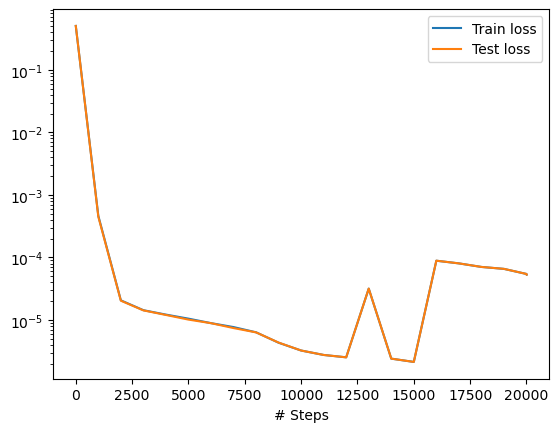

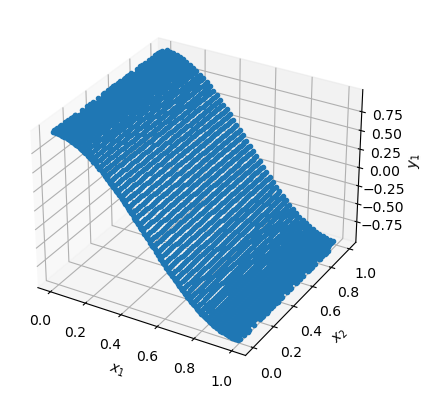

In [12]:
# Plot/print the results
dde.saveplot(relu_losshistory, relu_train_state, issave=True, isplot=True)

A continuación se prueba a reducir los puntos de entrenamiento dentro del dominio al 70%, usando la función de activación tanh.

In [14]:
# Define the PDE problem and configurations of the network:
data = dde.data.TimePDE(
    geomtime,
    pde, # minimize residual
    [bc, ic],
    num_domain=1778,
    num_boundary=80,
    num_initial=160,
    num_test=2540,
)
net = dde.nn.FNN([2] + [20] * 3 + [1], "tanh", "Glorot normal")
_70_model = dde.Model(data, net)

In [15]:
# Build and train the model:
_70_model.compile("adam", lr=1e-3)
_70_model.train(iterations=20000)
_70_model.compile("L-BFGS")
_70_losshistory, _70_train_state = _70_model.train()

Compiling model...
'compile' took 0.007279 s

Training model...

Step      Train loss                        Test loss                         Test metric
0         [2.63e-01, 1.29e-03, 5.24e-01]    [2.47e-01, 1.29e-03, 5.24e-01]    []  
1000      [4.93e-04, 3.56e-05, 1.89e-05]    [2.45e-04, 3.56e-05, 1.89e-05]    []  
2000      [7.99e-05, 6.60e-06, 2.43e-06]    [4.11e-05, 6.60e-06, 2.43e-06]    []  
3000      [4.41e-05, 3.21e-06, 1.75e-06]    [2.49e-05, 3.21e-06, 1.75e-06]    []  
4000      [3.05e-05, 2.25e-06, 1.42e-06]    [1.77e-05, 2.25e-06, 1.42e-06]    []  
5000      [2.38e-05, 2.29e-06, 1.51e-06]    [1.43e-05, 2.29e-06, 1.51e-06]    []  
6000      [2.01e-05, 1.49e-06, 1.21e-06]    [1.25e-05, 1.49e-06, 1.21e-06]    []  
7000      [2.53e-05, 2.73e-06, 1.00e-06]    [1.86e-05, 2.73e-06, 1.00e-06]    []  
8000      [1.50e-05, 1.13e-06, 9.48e-07]    [9.25e-06, 1.13e-06, 9.48e-07]    []  
9000      [1.34e-05, 8.94e-07, 7.97e-07]    [8.23e-06, 8.94e-07, 7.97e-07]    []  
10000     [1.21

Se observa que el Train loss sigue siendo mayor que el Test loss.

Saving loss history to C:\Users\reloj\Documents\loss.dat ...
Saving training data to C:\Users\reloj\Documents\train.dat ...
Saving test data to C:\Users\reloj\Documents\test.dat ...


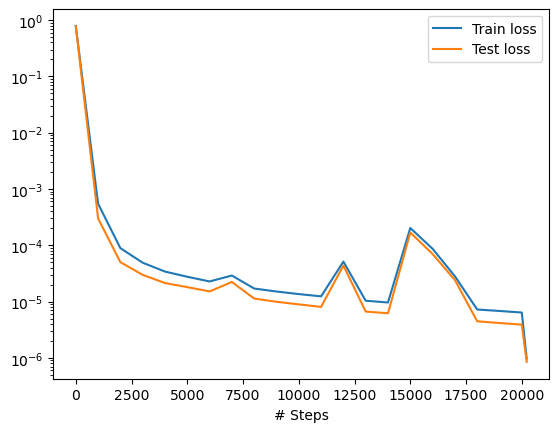

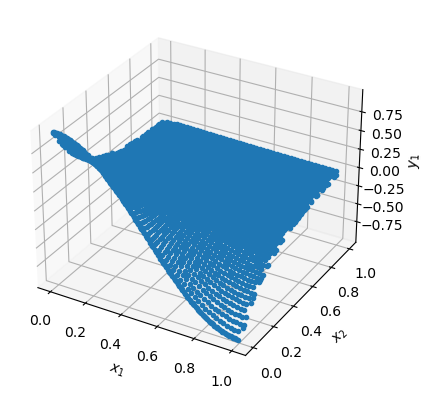

In [16]:
# Plot/print the results
dde.saveplot(_70_losshistory, _70_train_state, issave=True, isplot=True)

Ahora se reducen los puntos al 30%.


In [17]:
# Define the PDE problem and configurations of the network:
data = dde.data.TimePDE(
    geomtime,
    pde, # minimize residual
    [bc, ic],
    num_domain=762,
    num_boundary=80,
    num_initial=160,
    num_test=2540,
)
net = dde.nn.FNN([2] + [20] * 3 + [1], "tanh", "Glorot normal")
_30_model = dde.Model(data, net)

In [18]:
# Build and train the model:
_30_model.compile("adam", lr=1e-3)
_30_model.train(iterations=20000)
_30_model.compile("L-BFGS")
_30_losshistory, _30_train_state = _30_model.train()

Compiling model...
'compile' took 0.009919 s

Training model...

Step      Train loss                        Test loss                         Test metric
0         [2.74e-01, 1.07e-03, 5.24e-01]    [2.47e-01, 1.07e-03, 5.24e-01]    []  
1000      [9.24e-04, 7.38e-05, 1.22e-05]    [5.94e-04, 7.38e-05, 1.22e-05]    []  
2000      [8.66e-05, 4.20e-06, 9.00e-07]    [5.17e-05, 4.20e-06, 9.00e-07]    []  
3000      [5.22e-05, 3.09e-06, 6.33e-07]    [3.73e-05, 3.09e-06, 6.33e-07]    []  
4000      [3.34e-05, 1.91e-06, 5.60e-07]    [2.46e-05, 1.91e-06, 5.60e-07]    []  
5000      [2.49e-05, 1.46e-06, 4.52e-07]    [1.85e-05, 1.46e-06, 4.52e-07]    []  
6000      [1.95e-05, 9.78e-07, 3.71e-07]    [1.41e-05, 9.78e-07, 3.71e-07]    []  
7000      [1.59e-05, 9.66e-07, 2.66e-07]    [1.15e-05, 9.66e-07, 2.66e-07]    []  
8000      [1.12e-04, 1.54e-05, 5.41e-06]    [7.38e-05, 1.54e-05, 5.41e-06]    []  
9000      [7.14e-05, 1.20e-05, 6.54e-06]    [4.01e-05, 1.20e-05, 6.54e-06]    []  
10000     [1.51

Saving loss history to C:\Users\reloj\Documents\loss.dat ...
Saving training data to C:\Users\reloj\Documents\train.dat ...
Saving test data to C:\Users\reloj\Documents\test.dat ...


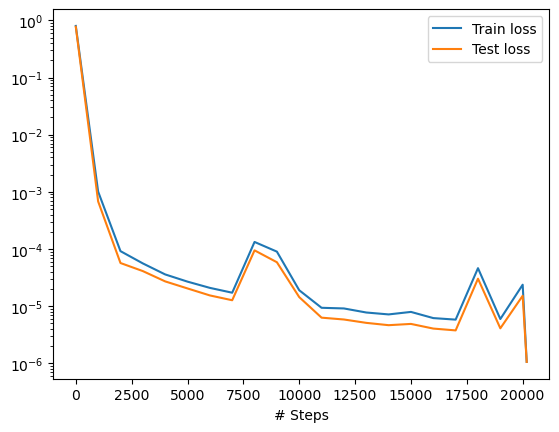

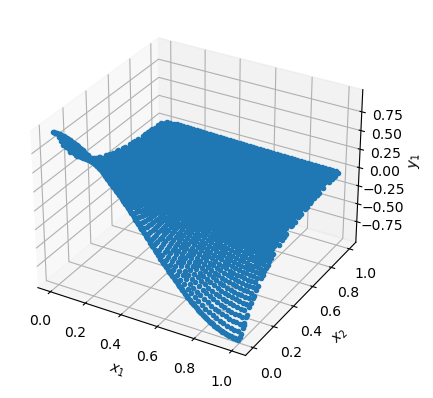

In [19]:
# Plot/print the results
dde.saveplot(_30_losshistory, _30_train_state, issave=True, isplot=True)

Reduciendo el número de puntos al 10%:

In [20]:
# Define the PDE problem and configurations of the network:
data = dde.data.TimePDE(
    geomtime,
    pde, # minimize residual
    [bc, ic],
    num_domain=254,
    num_boundary=80,
    num_initial=160,
    num_test=2540,
)
net = dde.nn.FNN([2] + [20] * 3 + [1], "tanh", "Glorot normal")
_10_model = dde.Model(data, net)

In [21]:
# Build and train the model:
_10_model.compile("adam", lr=1e-3)
_10_model.train(iterations=20000)
_10_model.compile("L-BFGS")
_10_losshistory, _10_train_state = _10_model.train()

Compiling model...
'compile' took 0.007110 s

Training model...

Step      Train loss                        Test loss                         Test metric
0         [3.00e-01, 1.23e-03, 5.24e-01]    [2.47e-01, 1.23e-03, 5.24e-01]    []  
1000      [2.94e-04, 7.15e-05, 1.52e-05]    [2.47e-04, 7.15e-05, 1.52e-05]    []  
2000      [9.81e-05, 1.40e-05, 1.47e-06]    [8.25e-05, 1.40e-05, 1.47e-06]    []  
3000      [4.60e-05, 4.17e-06, 7.46e-07]    [3.50e-05, 4.17e-06, 7.46e-07]    []  
4000      [2.66e-05, 1.53e-06, 6.53e-07]    [1.78e-05, 1.53e-06, 6.53e-07]    []  
5000      [4.09e-05, 2.73e-06, 5.50e-07]    [2.34e-05, 2.73e-06, 5.50e-07]    []  
6000      [1.45e-05, 5.50e-07, 3.16e-07]    [8.91e-06, 5.50e-07, 3.16e-07]    []  
7000      [1.23e-05, 4.72e-07, 2.77e-07]    [7.42e-06, 4.72e-07, 2.77e-07]    []  
8000      [1.08e-05, 4.27e-07, 2.60e-07]    [6.38e-06, 4.27e-07, 2.60e-07]    []  
9000      [9.85e-06, 4.08e-07, 2.34e-07]    [5.92e-06, 4.08e-07, 2.34e-07]    []  
10000     [8.73

Se observa que los picos parecen suavizarse según disminuye el número de puntos de entrenamiento.

Saving loss history to C:\Users\reloj\Documents\loss.dat ...
Saving training data to C:\Users\reloj\Documents\train.dat ...
Saving test data to C:\Users\reloj\Documents\test.dat ...


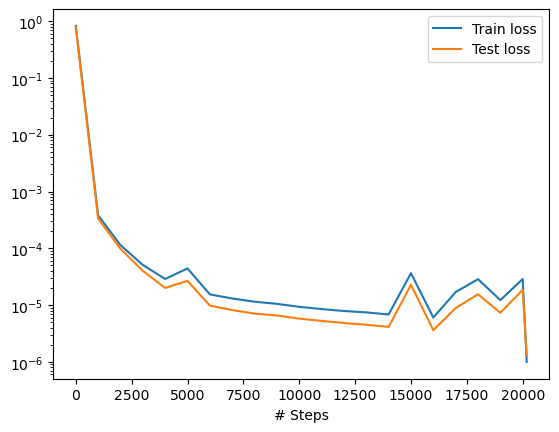

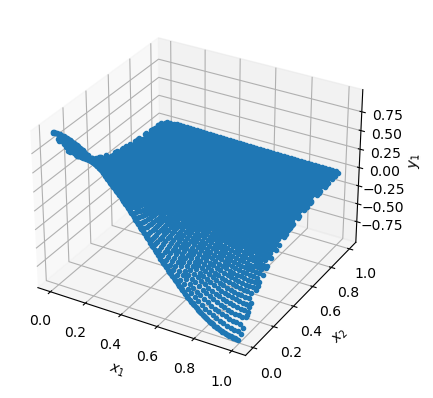

In [22]:
# Plot/print the results
dde.saveplot(_10_losshistory, _10_train_state, issave=True, isplot=True)

Ahora se usan solo 25 puntos dentro del dominio para entrenar.

In [23]:
# Define the PDE problem and configurations of the network:
data = dde.data.TimePDE(
    geomtime,
    pde, # minimize residual
    [bc, ic],
    num_domain=25,
    num_boundary=80,
    num_initial=160,
    num_test=2540,
)
net = dde.nn.FNN([2] + [20] * 3 + [1], "tanh", "Glorot normal")
_1_model = dde.Model(data, net)

In [24]:
# Build and train the model:
_1_model.compile("adam", lr=1e-3)
_1_model.train(iterations=20000)
_1_model.compile("L-BFGS")
_1_losshistory, _1_train_state = _1_model.train()

Compiling model...
'compile' took 0.007788 s

Training model...

Step      Train loss                        Test loss                         Test metric
0         [3.41e-01, 1.14e-03, 5.24e-01]    [2.47e-01, 1.14e-03, 5.24e-01]    []  
1000      [6.71e-04, 8.96e-05, 1.10e-05]    [4.22e-03, 8.96e-05, 1.10e-05]    []  
2000      [1.83e-04, 3.57e-05, 6.56e-06]    [9.52e-04, 3.57e-05, 6.56e-06]    []  
3000      [8.54e-05, 1.24e-05, 3.95e-06]    [4.75e-04, 1.24e-05, 3.95e-06]    []  
4000      [5.26e-05, 4.79e-06, 2.44e-06]    [3.03e-04, 4.79e-06, 2.44e-06]    []  
5000      [3.65e-05, 2.53e-06, 1.68e-06]    [2.24e-04, 2.53e-06, 1.68e-06]    []  
6000      [2.84e-05, 2.31e-06, 1.23e-06]    [1.83e-04, 2.31e-06, 1.23e-06]    []  
7000      [2.11e-05, 1.68e-06, 9.95e-07]    [1.58e-04, 1.68e-06, 9.95e-07]    []  
8000      [1.66e-05, 1.69e-06, 8.02e-07]    [1.42e-04, 1.69e-06, 8.02e-07]    []  
9000      [1.35e-05, 1.71e-06, 6.96e-07]    [1.31e-04, 1.71e-06, 6.96e-07]    []  
10000     [1.33

Finalmente, las curvas son bastante más suaves y el Train loss es menor que el Test loss.

Saving loss history to C:\Users\reloj\Documents\loss.dat ...
Saving training data to C:\Users\reloj\Documents\train.dat ...
Saving test data to C:\Users\reloj\Documents\test.dat ...


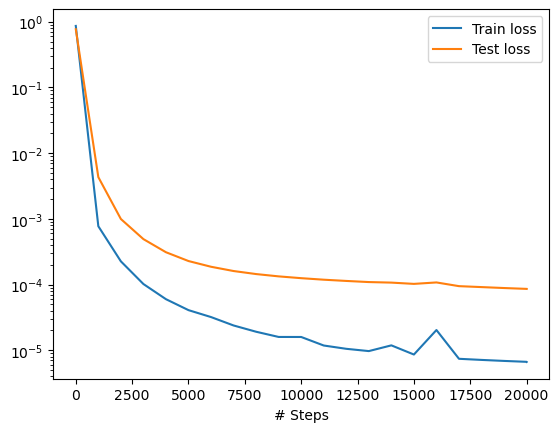

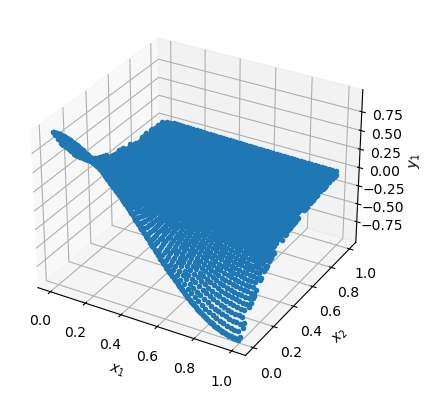

In [25]:
# Plot/print the results
dde.saveplot(_1_losshistory, _1_train_state, issave=True, isplot=True)

Esta última red es la misma que la anterior pero se entrena por 100000 iteraciones.

In [29]:
# Define the PDE problem and configurations of the network:
data = dde.data.TimePDE(
    geomtime,
    pde, # minimize residual
    [bc, ic],
    num_domain=25,
    num_boundary=80,
    num_initial=160,
    num_test=2540,
)
net = dde.nn.FNN([2] + [20] * 3 + [1], "tanh", "Glorot normal")
_model = dde.Model(data, net)

In [30]:
# Build and train the model:
_model.compile("adam", lr=1e-3)
_model.train(iterations=100000)
_model.compile("L-BFGS")
_losshistory, _train_state = _model.train()

Compiling model...
'compile' took 0.006959 s

Training model...

Step      Train loss                        Test loss                         Test metric
0         [3.43e-01, 1.23e-03, 5.24e-01]    [2.47e-01, 1.23e-03, 5.24e-01]    []  
1000      [6.34e-04, 8.19e-05, 1.23e-05]    [2.64e-03, 8.19e-05, 1.23e-05]    []  
2000      [1.81e-04, 2.35e-05, 4.28e-06]    [9.70e-04, 2.35e-05, 4.28e-06]    []  
3000      [8.17e-05, 8.92e-06, 3.96e-06]    [3.53e-04, 8.92e-06, 3.96e-06]    []  
4000      [7.97e-04, 4.58e-05, 9.89e-06]    [4.15e-04, 4.58e-05, 9.89e-06]    []  
5000      [3.09e-05, 3.53e-06, 2.41e-06]    [9.81e-05, 3.53e-06, 2.41e-06]    []  
6000      [4.22e-05, 3.92e-06, 1.81e-06]    [8.23e-05, 3.92e-06, 1.81e-06]    []  
7000      [1.87e-05, 2.08e-06, 1.61e-06]    [6.17e-05, 2.08e-06, 1.61e-06]    []  
8000      [1.59e-05, 1.63e-06, 1.34e-06]    [5.39e-05, 1.63e-06, 1.34e-06]    []  
9000      [1.34e-05, 1.26e-06, 1.16e-06]    [4.86e-05, 1.26e-06, 1.16e-06]    []  
10000     [1.17

97000     [1.22e-06, 1.60e-07, 2.49e-07]    [1.25e-05, 1.60e-07, 2.49e-07]    []  
98000     [2.16e-06, 1.80e-07, 2.79e-07]    [1.26e-05, 1.80e-07, 2.79e-07]    []  
99000     [1.23e-06, 1.57e-07, 2.54e-07]    [1.27e-05, 1.57e-07, 2.54e-07]    []  
100000    [1.21e-06, 1.53e-07, 2.49e-07]    [1.26e-05, 1.53e-07, 2.49e-07]    []  

Best model at step 96000:
  train loss: 1.59e-06
  test loss: 1.28e-05
  test metric: []

'train' took 385.424006 s

Compiling model...
'compile' took 0.037799 s

Training model...

Step      Train loss                        Test loss                         Test metric
100000    [1.21e-06, 1.53e-07, 2.49e-07]    [1.26e-05, 1.53e-07, 2.49e-07]    []  
100005    [1.16e-06, 1.51e-07, 2.48e-07]    [1.26e-05, 1.51e-07, 2.48e-07]    []  

Best model at step 100005:
  train loss: 1.56e-06
  test loss: 1.30e-05
  test metric: []

'train' took 2.261000 s



Saving loss history to C:\Users\reloj\Documents\loss.dat ...
Saving training data to C:\Users\reloj\Documents\train.dat ...
Saving test data to C:\Users\reloj\Documents\test.dat ...


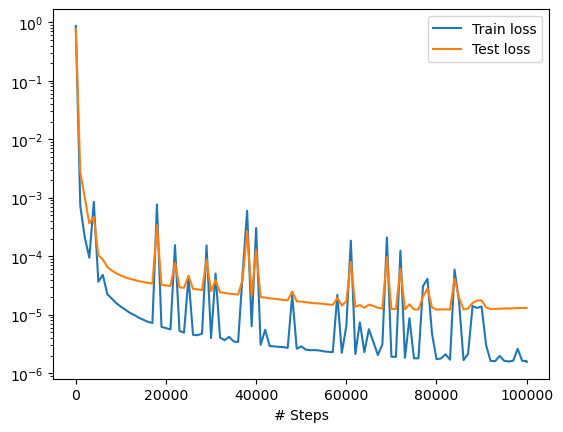

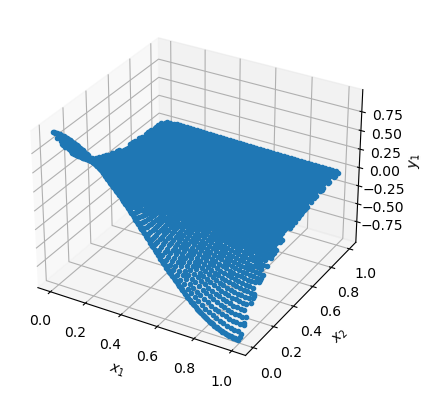

In [31]:
# Plot/print the results
dde.saveplot(_losshistory, _train_state, issave=True, isplot=True)

Se observa que en 100000 iteraciones aún no se ha llegado al overfitting.

A continuación, se entrena por un millón de iteraciones.

In [6]:
# Define the PDE problem and configurations of the network:
data = dde.data.TimePDE(
    geomtime, # dominio
    pde, # residuo a minimizar
    [bc, ic], # condiciones
    num_domain=25, # training points dentro del dominio
    num_boundary=80, # training/test points en el contorno
    num_initial=160, # training/test points en t=0
    num_test=2540, # test points dentro del dominio
)
net = dde.nn.FNN([2] + [20] * 3 + [1], "tanh", "Glorot normal")
model = dde.Model(data, net)

In [8]:
# Build and train the model:
model.compile("adam", lr=1e-3)
model.train(iterations=1000000)
model.compile("L-BFGS")
losshistory, train_state = model.train()

Compiling model...
'compile' took 0.022578 s

Training model...

Step      Train loss                        Test loss                         Test metric
0         [2.11e-02, 5.79e-03, 4.69e-01]    [2.08e-02, 5.79e-03, 4.69e-01]    []  
1000      [3.06e-04, 4.25e-05, 4.77e-05]    [2.09e-03, 4.25e-05, 4.77e-05]    []  
2000      [1.66e-04, 1.20e-05, 1.44e-05]    [7.64e-04, 1.20e-05, 1.44e-05]    []  
3000      [5.25e-05, 3.28e-06, 2.22e-06]    [3.84e-04, 3.28e-06, 2.22e-06]    []  
4000      [3.63e-05, 2.26e-06, 6.50e-07]    [2.90e-04, 2.26e-06, 6.50e-07]    []  
5000      [2.73e-05, 1.99e-06, 2.93e-07]    [2.42e-04, 1.99e-06, 2.93e-07]    []  
6000      [2.11e-05, 1.69e-06, 1.90e-07]    [2.12e-04, 1.69e-06, 1.90e-07]    []  
7000      [1.71e-05, 1.41e-06, 1.52e-07]    [1.91e-04, 1.41e-06, 1.52e-07]    []  
8000      [1.42e-05, 1.18e-06, 1.44e-07]    [1.75e-04, 1.18e-06, 1.44e-07]    []  
9000      [1.24e-05, 9.84e-07, 1.47e-07]    [1.64e-04, 9.84e-07, 1.47e-07]    []  
10000     [1.45

97000     [2.01e-06, 2.50e-07, 6.33e-08]    [6.72e-05, 2.50e-07, 6.33e-08]    []  
98000     [2.00e-06, 2.51e-07, 6.19e-08]    [6.74e-05, 2.51e-07, 6.19e-08]    []  
99000     [2.22e-06, 2.57e-07, 6.52e-08]    [6.76e-05, 2.57e-07, 6.52e-08]    []  
100000    [3.02e-06, 3.15e-07, 7.54e-08]    [6.87e-05, 3.15e-07, 7.54e-08]    []  
101000    [7.39e-05, 2.42e-06, 2.98e-06]    [7.53e-05, 2.42e-06, 2.98e-06]    []  
102000    [7.59e-05, 8.16e-06, 4.07e-07]    [6.92e-05, 8.16e-06, 4.07e-07]    []  
103000    [2.13e-04, 2.74e-05, 7.81e-07]    [1.49e-04, 2.74e-05, 7.81e-07]    []  
104000    [1.84e-06, 2.46e-07, 6.21e-08]    [6.60e-05, 2.46e-07, 6.21e-08]    []  
105000    [4.08e-06, 3.70e-07, 1.44e-07]    [6.28e-05, 3.70e-07, 1.44e-07]    []  
106000    [2.12e-05, 7.90e-07, 4.15e-07]    [7.80e-05, 7.90e-07, 4.15e-07]    []  
107000    [2.49e-06, 3.03e-07, 6.31e-08]    [6.76e-05, 3.03e-07, 6.31e-08]    []  
108000    [1.77e-06, 2.46e-07, 6.20e-08]    [6.53e-05, 2.46e-07, 6.20e-08]    []  
1090

196000    [7.11e-07, 2.13e-07, 4.56e-08]    [4.65e-05, 2.13e-07, 4.56e-08]    []  
197000    [1.66e-06, 2.45e-07, 7.53e-08]    [4.49e-05, 2.45e-07, 7.53e-08]    []  
198000    [2.21e-05, 2.73e-06, 1.46e-07]    [6.03e-05, 2.73e-06, 1.46e-07]    []  
199000    [6.63e-07, 2.07e-07, 4.64e-08]    [4.60e-05, 2.07e-07, 4.64e-08]    []  
200000    [2.18e-06, 2.96e-07, 4.94e-08]    [4.81e-05, 2.96e-07, 4.94e-08]    []  
201000    [5.18e-06, 6.00e-07, 1.07e-07]    [4.21e-05, 6.00e-07, 1.07e-07]    []  
202000    [3.20e-06, 3.43e-07, 7.52e-08]    [4.80e-05, 3.43e-07, 7.52e-08]    []  
203000    [6.32e-07, 2.00e-07, 4.76e-08]    [4.51e-05, 2.00e-07, 4.76e-08]    []  
204000    [1.01e-04, 1.18e-05, 6.68e-07]    [8.75e-05, 1.18e-05, 6.68e-07]    []  
205000    [9.97e-05, 5.70e-06, 1.88e-06]    [5.63e-05, 5.70e-06, 1.88e-06]    []  
206000    [1.26e-06, 2.35e-07, 6.28e-08]    [4.41e-05, 2.35e-07, 6.28e-08]    []  
207000    [6.07e-07, 1.99e-07, 4.60e-08]    [4.45e-05, 1.99e-07, 4.60e-08]    []  
2080

295000    [5.16e-07, 1.67e-07, 5.41e-08]    [3.21e-05, 1.67e-07, 5.41e-08]    []  
296000    [1.02e-06, 2.07e-07, 5.07e-08]    [3.30e-05, 2.07e-07, 5.07e-08]    []  
297000    [4.03e-06, 7.63e-07, 3.39e-07]    [2.95e-05, 7.63e-07, 3.39e-07]    []  
298000    [4.75e-07, 1.68e-07, 4.93e-08]    [3.22e-05, 1.68e-07, 4.93e-08]    []  
299000    [4.68e-07, 1.61e-07, 5.36e-08]    [3.18e-05, 1.61e-07, 5.36e-08]    []  
300000    [4.46e-07, 1.61e-07, 5.18e-08]    [3.18e-05, 1.61e-07, 5.18e-08]    []  
301000    [5.12e-07, 1.78e-07, 7.00e-08]    [3.20e-05, 1.78e-07, 7.00e-08]    []  
302000    [4.33e-07, 1.57e-07, 5.37e-08]    [3.13e-05, 1.57e-07, 5.37e-08]    []  
303000    [2.56e-05, 2.42e-06, 2.05e-07]    [4.07e-05, 2.42e-06, 2.05e-07]    []  
304000    [5.53e-07, 1.69e-07, 5.81e-08]    [3.09e-05, 1.69e-07, 5.81e-08]    []  
305000    [8.62e-07, 1.89e-07, 5.75e-08]    [3.13e-05, 1.89e-07, 5.75e-08]    []  
306000    [2.75e-05, 3.59e-06, 1.33e-07]    [4.45e-05, 3.59e-06, 1.33e-07]    []  
3070

394000    [1.85e-04, 1.49e-05, 2.51e-06]    [7.33e-05, 1.49e-05, 2.51e-06]    []  
395000    [1.60e-06, 2.70e-07, 9.35e-08]    [2.47e-05, 2.70e-07, 9.35e-08]    []  
396000    [3.26e-07, 1.41e-07, 9.11e-08]    [2.41e-05, 1.41e-07, 9.11e-08]    []  
397000    [5.98e-07, 1.63e-07, 9.88e-08]    [2.39e-05, 1.63e-07, 9.88e-08]    []  
398000    [1.24e-06, 3.02e-07, 1.33e-07]    [2.46e-05, 3.02e-07, 1.33e-07]    []  
399000    [1.64e-04, 1.53e-05, 1.57e-06]    [7.65e-05, 1.53e-05, 1.57e-06]    []  
400000    [1.81e-06, 1.88e-07, 1.38e-07]    [2.37e-05, 1.88e-07, 1.38e-07]    []  
401000    [3.18e-07, 1.40e-07, 9.37e-08]    [2.38e-05, 1.40e-07, 9.37e-08]    []  
402000    [4.43e-06, 3.40e-07, 1.80e-07]    [2.55e-05, 3.40e-07, 1.80e-07]    []  
403000    [6.91e-05, 4.64e-06, 8.42e-07]    [3.26e-05, 4.64e-06, 8.42e-07]    []  
404000    [5.95e-07, 1.60e-07, 9.48e-08]    [2.38e-05, 1.60e-07, 9.48e-08]    []  
405000    [1.70e-06, 2.98e-07, 1.19e-07]    [2.32e-05, 2.98e-07, 1.19e-07]    []  
4060

493000    [2.18e-05, 1.77e-06, 3.26e-07]    [2.65e-05, 1.77e-06, 3.26e-07]    []  
494000    [3.53e-07, 1.18e-07, 1.03e-07]    [2.14e-05, 1.18e-07, 1.03e-07]    []  
495000    [2.70e-07, 1.21e-07, 9.18e-08]    [2.19e-05, 1.21e-07, 9.18e-08]    []  
496000    [1.31e-05, 1.91e-06, 1.36e-07]    [2.70e-05, 1.91e-06, 1.36e-07]    []  
497000    [2.40e-05, 3.36e-06, 1.02e-06]    [3.07e-05, 3.36e-06, 1.02e-06]    []  
498000    [6.06e-06, 1.05e-06, 1.69e-07]    [2.17e-05, 1.05e-06, 1.69e-07]    []  
499000    [8.38e-05, 1.16e-05, 9.55e-07]    [4.12e-05, 1.16e-05, 9.55e-07]    []  
500000    [5.48e-06, 7.89e-07, 9.25e-08]    [2.50e-05, 7.89e-07, 9.25e-08]    []  
501000    [2.74e-07, 1.12e-07, 9.98e-08]    [2.15e-05, 1.12e-07, 9.98e-08]    []  
502000    [6.96e-07, 1.39e-07, 9.40e-08]    [2.24e-05, 1.39e-07, 9.40e-08]    []  
503000    [1.61e-06, 1.80e-07, 1.14e-07]    [2.09e-05, 1.80e-07, 1.14e-07]    []  
504000    [4.80e-06, 6.97e-07, 1.97e-07]    [2.38e-05, 6.97e-07, 1.97e-07]    []  
5050

592000    [9.52e-07, 1.82e-07, 1.00e-07]    [2.05e-05, 1.82e-07, 1.00e-07]    []  
593000    [1.16e-06, 1.47e-07, 9.49e-08]    [2.15e-05, 1.47e-07, 9.49e-08]    []  
594000    [2.01e-07, 7.62e-08, 8.17e-08]    [2.04e-05, 7.62e-08, 8.17e-08]    []  
595000    [1.15e-05, 2.04e-06, 1.85e-07]    [2.16e-05, 2.04e-06, 1.85e-07]    []  
596000    [2.39e-07, 7.96e-08, 8.03e-08]    [2.06e-05, 7.96e-08, 8.03e-08]    []  
597000    [2.40e-07, 7.85e-08, 8.28e-08]    [2.04e-05, 7.85e-08, 8.28e-08]    []  
598000    [9.04e-06, 1.09e-06, 1.92e-07]    [2.38e-05, 1.09e-06, 1.92e-07]    []  
599000    [4.15e-07, 8.76e-08, 9.13e-08]    [2.02e-05, 8.76e-08, 9.13e-08]    []  
600000    [9.11e-06, 8.59e-07, 2.09e-07]    [2.16e-05, 8.59e-07, 2.09e-07]    []  
601000    [1.71e-06, 2.84e-07, 1.03e-07]    [1.97e-05, 2.84e-07, 1.03e-07]    []  
602000    [3.53e-06, 3.96e-07, 1.09e-07]    [2.04e-05, 3.96e-07, 1.09e-07]    []  
603000    [7.46e-07, 9.31e-08, 9.14e-08]    [1.98e-05, 9.31e-08, 9.14e-08]    []  
6040

691000    [1.37e-06, 4.06e-07, 3.56e-07]    [1.93e-05, 4.06e-07, 3.56e-07]    []  
692000    [2.58e-07, 6.17e-08, 6.61e-08]    [1.92e-05, 6.17e-08, 6.61e-08]    []  
693000    [5.31e-05, 4.37e-06, 8.46e-07]    [3.79e-05, 4.37e-06, 8.46e-07]    []  
694000    [1.97e-07, 5.82e-08, 6.52e-08]    [1.89e-05, 5.82e-08, 6.52e-08]    []  
695000    [1.91e-07, 5.82e-08, 6.16e-08]    [1.89e-05, 5.82e-08, 6.16e-08]    []  
696000    [6.53e-07, 1.30e-07, 5.23e-08]    [1.95e-05, 1.30e-07, 5.23e-08]    []  
697000    [5.84e-06, 9.44e-07, 1.22e-07]    [1.98e-05, 9.44e-07, 1.22e-07]    []  
698000    [1.97e-07, 5.79e-08, 5.96e-08]    [1.89e-05, 5.79e-08, 5.96e-08]    []  
699000    [2.10e-06, 2.53e-07, 4.29e-07]    [1.89e-05, 2.53e-07, 4.29e-07]    []  
700000    [2.76e-05, 1.39e-06, 3.90e-07]    [2.99e-05, 1.39e-06, 3.90e-07]    []  
701000    [1.86e-07, 5.44e-08, 6.03e-08]    [1.89e-05, 5.44e-08, 6.03e-08]    []  
702000    [1.03e-05, 1.36e-06, 1.32e-07]    [1.81e-05, 1.36e-06, 1.32e-07]    []  
7030

790000    [3.92e-07, 7.42e-08, 6.27e-08]    [1.80e-05, 7.42e-08, 6.27e-08]    []  
791000    [1.78e-07, 4.25e-08, 4.68e-08]    [1.77e-05, 4.25e-08, 4.68e-08]    []  
792000    [4.66e-07, 6.27e-08, 5.95e-08]    [1.76e-05, 6.27e-08, 5.95e-08]    []  
793000    [2.04e-07, 4.93e-08, 4.58e-08]    [1.76e-05, 4.93e-08, 4.58e-08]    []  
794000    [1.68e-05, 5.24e-07, 3.63e-07]    [1.77e-05, 5.24e-07, 3.63e-07]    []  
795000    [3.97e-07, 5.29e-08, 5.33e-08]    [1.72e-05, 5.29e-08, 5.33e-08]    []  
796000    [5.26e-06, 8.96e-07, 2.21e-07]    [1.87e-05, 8.96e-07, 2.21e-07]    []  
797000    [3.35e-07, 5.31e-08, 4.68e-08]    [1.81e-05, 5.31e-08, 4.68e-08]    []  
798000    [3.64e-05, 1.75e-06, 3.59e-07]    [1.88e-05, 1.75e-06, 3.59e-07]    []  
799000    [7.18e-06, 1.42e-06, 6.02e-07]    [1.96e-05, 1.42e-06, 6.02e-07]    []  
800000    [8.43e-05, 6.74e-06, 5.33e-07]    [2.37e-05, 6.74e-06, 5.33e-07]    []  
801000    [2.59e-06, 5.28e-07, 1.35e-07]    [1.82e-05, 5.28e-07, 1.35e-07]    []  
8020

889000    [2.67e-07, 4.94e-08, 3.80e-08]    [1.64e-05, 4.94e-08, 3.80e-08]    []  
890000    [7.17e-07, 1.02e-07, 4.42e-08]    [1.68e-05, 1.02e-07, 4.42e-08]    []  
891000    [1.74e-07, 4.07e-08, 5.18e-08]    [1.62e-05, 4.07e-08, 5.18e-08]    []  
892000    [1.22e-06, 2.10e-07, 5.31e-08]    [1.66e-05, 2.10e-07, 5.31e-08]    []  
893000    [6.02e-05, 1.05e-05, 1.14e-06]    [3.20e-05, 1.05e-05, 1.14e-06]    []  
894000    [1.69e-07, 3.38e-08, 3.56e-08]    [1.61e-05, 3.38e-08, 3.56e-08]    []  
895000    [4.32e-07, 4.45e-08, 4.02e-08]    [1.56e-05, 4.45e-08, 4.02e-08]    []  
896000    [1.72e-07, 3.42e-08, 3.57e-08]    [1.61e-05, 3.42e-08, 3.57e-08]    []  
897000    [2.19e-07, 5.77e-08, 1.12e-07]    [1.60e-05, 5.77e-08, 1.12e-07]    []  
898000    [9.04e-07, 1.72e-07, 4.03e-08]    [1.60e-05, 1.72e-07, 4.03e-08]    []  
899000    [5.31e-07, 9.02e-08, 4.11e-08]    [1.64e-05, 9.02e-08, 4.11e-08]    []  
900000    [2.44e-07, 4.00e-08, 3.73e-08]    [1.57e-05, 4.00e-08, 3.73e-08]    []  
9010

988000    [8.09e-06, 5.23e-07, 7.82e-08]    [1.94e-05, 5.23e-07, 7.82e-08]    []  
989000    [1.55e-07, 2.73e-08, 2.62e-08]    [1.46e-05, 2.73e-08, 2.62e-08]    []  
990000    [2.12e-07, 3.22e-08, 2.50e-08]    [1.49e-05, 3.22e-08, 2.50e-08]    []  
991000    [1.08e-06, 1.16e-07, 5.39e-08]    [1.59e-05, 1.16e-07, 5.39e-08]    []  
992000    [2.25e-07, 2.85e-08, 3.02e-08]    [1.44e-05, 2.85e-08, 3.02e-08]    []  
993000    [3.05e-06, 4.30e-07, 7.97e-08]    [1.70e-05, 4.30e-07, 7.97e-08]    []  
994000    [2.72e-07, 3.10e-08, 2.88e-08]    [1.43e-05, 3.10e-08, 2.88e-08]    []  
995000    [8.51e-06, 1.10e-06, 6.40e-07]    [1.58e-05, 1.10e-06, 6.40e-07]    []  
996000    [5.40e-06, 5.92e-07, 8.79e-08]    [1.82e-05, 5.92e-07, 8.79e-08]    []  
997000    [1.55e-07, 2.65e-08, 2.60e-08]    [1.46e-05, 2.65e-08, 2.60e-08]    []  
998000    [2.37e-05, 1.53e-06, 1.63e-07]    [2.48e-05, 1.53e-06, 1.63e-07]    []  
999000    [3.66e-06, 1.25e-06, 1.64e-06]    [1.46e-05, 1.25e-06, 1.64e-06]    []  
1000

Saving loss history to C:\Users\reloj\Documents\loss.dat ...
Saving training data to C:\Users\reloj\Documents\train.dat ...
Saving test data to C:\Users\reloj\Documents\test.dat ...


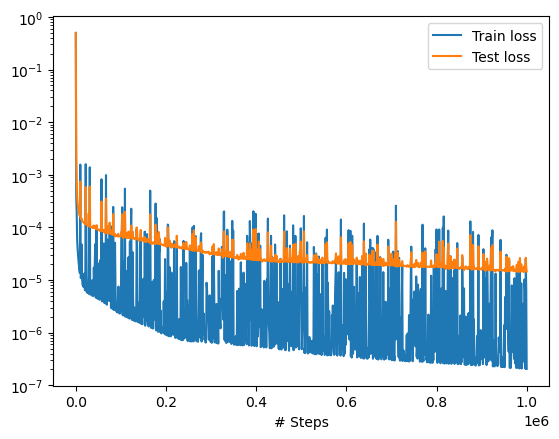

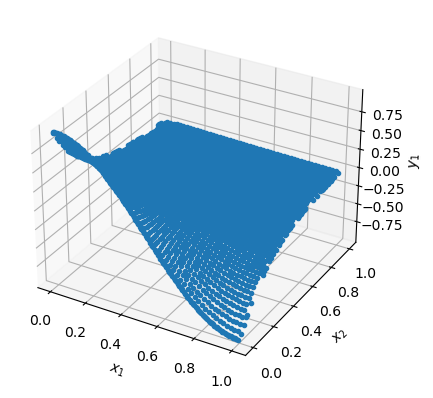

In [9]:
# Plot/print the results
dde.saveplot(losshistory, train_state, issave=True, isplot=True)